## Image By Image Test

In [1]:
import os
import cv2
import time
import math
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch.nn import functional as F

import warnings
import _thread
from utils import *
from queue import Queue

In [2]:
model_dir = "train_log"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)
if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
model = load_model(model_dir)

Loaded v3.x HD model.


In [7]:
left_frame = "./test_images/442.png"
right_frame = "./test_images/444.png"
left_frame = cv2.cvtColor(cv2.imread(left_frame, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
right_frame = cv2.cvtColor(cv2.imread(right_frame, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
h, w, _ = left_frame.shape

tmp = max(32, int(32 / 0.5))
ph = ((h - 1) // tmp + 1) * tmp
pw = ((w - 1) // tmp + 1) * tmp
padding = (0, pw - w, 0, ph - h)

In [8]:
def get_padding_image(image, padding):
    image = torch.from_numpy(np.transpose(image, (2,0,1))).to(device, non_blocking=True).unsqueeze(0).float() / 255.
    return pad_image(image, padding)

def make_inference(I0, I1, n, scale):
    middle = model.inference(I0, I1, scale)
    if n == 1:
        return [middle]
    first_half = make_inference(I0, middle, n=n//2, scale=scale)
    second_half = make_inference(middle, I1, n=n//2, scale=scale)
    if n % 2:
        return [*first_half, middle, *second_half]
    else:
        return [*first_half, *second_half]

In [9]:
with torch.no_grad():
    left_frame = get_padding_image(left_frame, padding)
    right_frame = get_padding_image(right_frame, padding)
    output = make_inference(left_frame, right_frame, 1, 0.5)

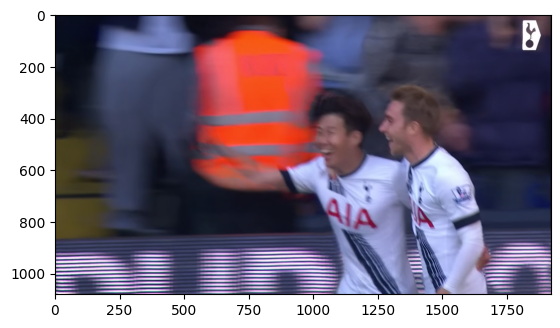

In [10]:
for mid in output:
    mid = (((mid[0] * 255.).byte().cpu().numpy().transpose(1, 2, 0)))
    cv2.imwrite(f"output.png", cv2.cvtColor(mid[:h, :w], cv2.COLOR_BGR2RGB))
    plt.imshow(mid[:h, :w])

## Read Video

In [1]:
import cv2

In [2]:
video_path = "C:\\Users\\gemiso\\Desktop\\frame_interpol_videos\\20240508_뉴스_01_YNT_2m.mxf"
capture = cv2.VideoCapture(video_path)